# PointNet for particle flow

<div class="alert alert-block alert-success">
This notebook reproduces the full analysis seen in notebook 00-all-in-once, but implementing MLOps best practice and exploiting W&B for experiment tracking.

**Main changes:** 

- use artifacts to fetch inputs (data) and store outputs (model)
- log data stats and visualizations
- log training metrics and configuration
- log prediction table to inspect results and debug applications

</div>

## Problem

This dataset contains a Monte Carlo simulation of $\rho^{\pm} \rightarrow \pi^{\pm} + \pi^0$ decays and the corresponding detector response. Specifically, the data report the measured response of **i) tracker** and **ii) calorimeter**, along with the true pyshical quantitites that generated those measurements.

<div class="alert alert-block alert-info">
This means that we expect one track per event, with mainly two energy blobs (clusters of cells) in the calorimeter.
</div>

The final **goal** is to associate the cell signals observed in the calorimeter to the track that caused those energy deposits.

## Method

The idea is to leverage a **point cloud** data representation to combine tracker and calorimeter information so to associate cell hits to the corresponding track. We will use a [**PointNet**](https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf) model that is capable of handling this type of data, framed as a **semantic segmentation** approach. More precisely, this means that:
- we represent each hit in the detector as a point in the point cloud: x, y, z coordinates + additional features ("3+"-dimensional point)
- the **learning task** will be binary classification at hit level: for each cell the model learns whether its energy comes mostly from the track (class 1) or not (class 0)

## Data structure

<div class="alert alert-block alert-info">

This dataset is organized as follows:
 - for each event, we create a **sample** (i.e. point cloud)
 - each sample contains all hits in a cone around a track of the event, called **focal track**
     - the cone includes all hits within some $\Delta R$ distance of the track
     - if an event has multiple tracks, then we have more samples per event
     - since different samples have possibly different number of hits, **we pad all point clouds to ensure they have same size** (needed since the model requires inputs of same size)

</div>

## Settings & config

This section collects all configuration variables and training/model hyperparameters. 

The idea is to put it at the top so that it is easy to find and edit.

In [1]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

# path settings
REPO_BASEPATH = Path().cwd().parent
DATA_PATH = REPO_BASEPATH / "pnet_data/raw/rho_small.npz"
CODE_PATH = REPO_BASEPATH / "src"
sys.path.append(str(CODE_PATH))
MODEL_CHECKPOINTS_PATH = REPO_BASEPATH / "results" / "models" / "pointnet_baseline.weights.h5"

import wandb
from data_viz import *
from model_utils import *

LABELS = ["unfocus hit", "focus hit"]

# set random seed for reproducibility
SEED = 18
set_global_seeds(SEED)

# data settings
N_TRAIN, N_VAL, N_TEST = 210, 65, 50 # roughly 0.65, 0.2, 0.15

# model settings
N_FEATURES = 3
INIT_SIZE = 8
END_SIZE = 16

# training settings
BATCH_SIZE = 16
EPOCHS = 20
INIT_LR = 0.003


2024-11-26 12:50:05.620877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 12:50:07.933674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Model training

We proceed with model training:

1. split the data
1. build our PointNet model using Tensorflow/Keras
1. create a dataloader to feed batches into our model
1. train
1. check results

### PointNet model 

We use a PointNet model for semantic segmentation. Here is an illustration of its structure:

![PointNet architecture](../pnet_data/images/pointnet-architecture.jpg)

We have two heads:
 - classification head (used for point cloud classification)
 - segmentation head (used for semantic segmentation)

We are going to use the **segmentation head** for our problem. The architecture settings we can experiment with are:
 - `n_features` (the number of input features): original version has only size 3 as it only takes x,y,z coordinates
 - `init_size` (number of filters of first convolutional layer): original version has 64
 - `end_size` (number of filters in segmentation head): original version has 128

### Tensorflow datasets

In [3]:
def read_data(split, bin_cutoff=0.5, n_classes=2):
    split_data_path = DATA_PATH.parent.parent
    filepath=str(split_data_path / f"{split}_data" / DATA_PATH.name)
    data = np.load(filepath)['feats']
    target_class = [(energy_fraction > bin_cutoff).astype(np.float32) 
                    for energy_fraction in data['truth_cell_focal_fraction_energy']]
    # target_class = (events["truth_cell_focal_fraction_energy"] > 0.5).reshape(-1)
    target_class = keras.utils.to_categorical(target_class, num_classes=n_classes)
    return data, target_class

In [4]:
# load data
# we could also retrieve training and validation data from artifacts
# split="train"
# data_artifact = run.use_artifact(f"{split}:latest")
# data_path = data_artifact.download(root=REPO_BASEPATH / f"pnet_data/{split}")
# filepath=str(Path(data_path) / DATA_PATH.name)
# data = np.load(filepath)['feats']

input_features = ["normalized_x", "normalized_y", "normalized_z"]

train_data, train_label_cloud = read_data("train")

train_point_clouds = train_data[input_features]
total_training_examples = len(train_point_clouds)

val_data, val_label_cloud = read_data("val")
val_point_clouds = val_data[input_features]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

n_points = train_point_clouds[0].shape[0]
n_features = len(train_point_clouds[0].dtype.names)
n_classes = len(LABELS)

Num train point clouds: 210
Num train point cloud labels: 210
Num val point clouds: 65
Num val point cloud labels: 65


## Training 

In [5]:
def train(cfg):
    steps_per_epoch = total_training_examples // cfg.batch_size
    total_training_steps = steps_per_epoch * cfg.epochs
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=cfg.init_lr,
        decay_steps=steps_per_epoch * 5,
        decay_rate=0.5,
        staircase=True,
    )

    segmentation_model = get_shape_segmentation_model(cfg.n_points, cfg.n_classes, cfg.n_features,
                                                      cfg.init_size, cfg.end_size)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
        jit_compile=False
    )

    MODEL_CHECKPOINTS_PATH.parent.mkdir(exist_ok=True, parents=True)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        MODEL_CHECKPOINTS_PATH,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=cfg.epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(MODEL_CHECKPOINTS_PATH)
    return segmentation_model, history

### Manual metrics logging 

One way to log metrics and stuff we want to monitor during training is to manually call wandb.log every time we want to record a value:

    e.g.: wandb.log({'epoch': epoch, 'lr': lr, 'loss': loss, 'val_loss': val_loss}) to track important elements of our training loop

In [6]:
experiment_config = dict(
    DATA_PATH= DATA_PATH, seed=SEED, bin_cutoff=0.5, input_features=input_features,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    n_points=n_points, n_classes=n_classes, n_features=n_features,
    init_lr=INIT_LR, init_size=INIT_SIZE, end_size=END_SIZE, 
)

with wandb.init(project="mlops-ai_infn", entity="lclissa", name="first-training",
                job_type="training", config=experiment_config,
                notes="Manual logging ...") as run:
    cfg = run.config
    _ = run.use_artifact("train_data:latest")
    _ = run.use_artifact("val_data:latest")
    train_dataset = generate_dataset(train_point_clouds, train_label_cloud, 
                                 bs=cfg.batch_size, n_points=cfg.n_points, n_features=cfg.n_features, labels=LABELS)
    val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False, 
                                   bs=cfg.batch_size, n_points=cfg.n_points, n_features=cfg.n_features, labels=LABELS)
    
    segmentation_model, history = train(cfg=run.config)   
    
    # manually logging history
    metrics = history.history
    ep=1
    for loss, val_loss, acc, val_acc in zip(metrics['loss'], metrics['val_loss'], metrics['accuracy'], metrics['val_accuracy']):
        run.log({
            'epoch': ep,
            'loss': loss, 'val_loss': val_loss,
            'accuracy': acc, 'val_accuracy': val_acc
        })
        ep +=1

    model_artifact = wandb.Artifact('baseline-model', type='model', description="First training",
                                   metadata=cfg.as_dict())
    model_artifact.add_file(MODEL_CHECKPOINTS_PATH)
    run.log_artifact(model_artifact)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lclissa. Use `wandb login --relogin` to force relogin


2024-11-26 12:50:15.051740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 12:50:15.103649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 12:50:15.106625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-11-26 12:50:24.444746: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1732625425.080134   14042 service.cc:145] XLA service 0x7f34d40ed690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732625425.080198   14042 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1732625425.223817   14042 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.4640 - loss: 7.7776 - val_accuracy: 0.8734 - val_loss: 6.5292
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8468 - loss: 5.1477 - val_accuracy: 0.8734 - val_loss: 5.3446
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8739 - loss: 4.9179 - val_accuracy: 0.8734 - val_loss: 4.8988
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8749 - loss: 4.8426 - val_accuracy: 0.8734 - val_loss: 4.8922
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8871 - loss: 4.7851 - val_accuracy: 0.8734 - val_loss: 4.9945
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8781 - loss: 4.7302 - val_accuracy: 0.8734 - val_loss: 4.9663
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8784 - loss: 4.6987 - val_accuracy: 0.8734 - val_loss: 4.8056
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8744 - loss: 4.6412 - val_accuracy: 0.8734 - val_loss: 

accuracy,▁▇██████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█████████████████▆▁▄
val_loss,█▄▂▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.88382
epoch,20
loss,4.53803
val_accuracy,0.86938
val_loss,4.51547


### wandb Callback

Alternatively, many Deep Learning libraries have their own callbacks that serve as integrations of wandb. These are useful to log all main quantities we may be interested in out of the box, without needing to re-write boilerplate code.

For Tensorflow and Keras, the callbacks are in `wandb.keras` module, e.g. 

 - `WandbMetricsLogger`: log training metrics
 - `WandbModelCheckpoint` log artifact for model checkpoint

These work as normal callbacks, so we just need to pass them to the `.fit()` method. 

In [15]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

def train(cfg):
    steps_per_epoch = total_training_examples // cfg.batch_size
    total_training_steps = steps_per_epoch * cfg.epochs
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=cfg.init_lr,
        decay_steps=steps_per_epoch * 5,
        decay_rate=0.5,
        staircase=True,
    )

    segmentation_model = get_shape_segmentation_model(cfg.n_points, cfg.n_classes, cfg.n_features,
                                                      cfg.init_size, cfg.end_size)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
        jit_compile=False
    )

    MODEL_CHECKPOINTS_PATH.parent.mkdir(exist_ok=True, parents=True)
    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=cfg.epochs,
        callbacks=[#checkpoint_callback, 
                   # add wandb callbacks
                   WandbMetricsLogger(log_freq=1),
                   WandbModelCheckpoint(
                       MODEL_CHECKPOINTS_PATH, #.parent / "model-{epoch:02d}-{val_loss:.2f}.weights.h5",
                       monitor="val_loss",
                       save_best_only=True,
                       save_weights_only=True,
                   )
                    ],
    )

    segmentation_model.load_weights(MODEL_CHECKPOINTS_PATH)
    return segmentation_model, history
    
with wandb.init(project="mlops-ai_infn", entity="lclissa", name="callbacks-training",
                job_type="training", config=experiment_config,
                notes="Using Callbacks ...") as run:
    cfg = run.config
    _ = run.use_artifact("train_data:latest")
    _ = run.use_artifact("val_data:latest")
    train_dataset = generate_dataset(train_point_clouds, train_label_cloud, 
                                 bs=cfg.batch_size, n_points=cfg.n_points, n_features=cfg.n_features, labels=LABELS)
    val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False, 
                                   bs=cfg.batch_size, n_points=cfg.n_points, n_features=cfg.n_features, labels=LABELS)
    
    segmentation_model, history = train(cfg=run.config)   

    model_artifact = wandb.Artifact('baseline-model', type='model', description="Callback training",
                                   metadata=cfg.as_dict())
    model_artifact.add_file(MODEL_CHECKPOINTS_PATH)
    run.log_artifact(model_artifact)

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.7189 - loss: 7.5599 - val_accuracy: 0.8733 - val_loss: 6.6367
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8621 - loss: 5.0434 - val_accuracy: 0.8734 - val_loss: 5.4942
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8694 - loss: 4.8654 - val_accuracy: 0.8734 - val_loss: 5.2390
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8759 - loss: 4.7487 - val_accuracy: 0.8734 - val_loss: 4.9957
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8775 - loss: 4.6759 - val_accuracy: 0.8734 - val_loss: 4.8696
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8763 - loss: 4.6396 - val_accuracy: 0.8734 - val_loss: 4.9000
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8905 - loss: 4.6180 - val_accuracy: 0.8734 - val_loss: 4.8370
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8827 - loss: 4.6189 - val_accuracy: 0.8734 - 

batch/accuracy,▁▆▆▆▇▆▆▆▇▇▇▇▆▇█▆▇▆▆▇▆▇▇▇▇▇▇▆▆▇▆▆▇▇█▇▇▆▆▆
batch/batch_step,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
batch/learning_rate,████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
batch/loss,█▇▅▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▆▇█▇▇▇▇▇██▇▇███▇▇▇
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,████▄▄▄▄▄▂▂▂▂▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,██████████████▆▃▁▃▂▁
epoch/val_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
batch/accuracy,0.8759


### Model debugging

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


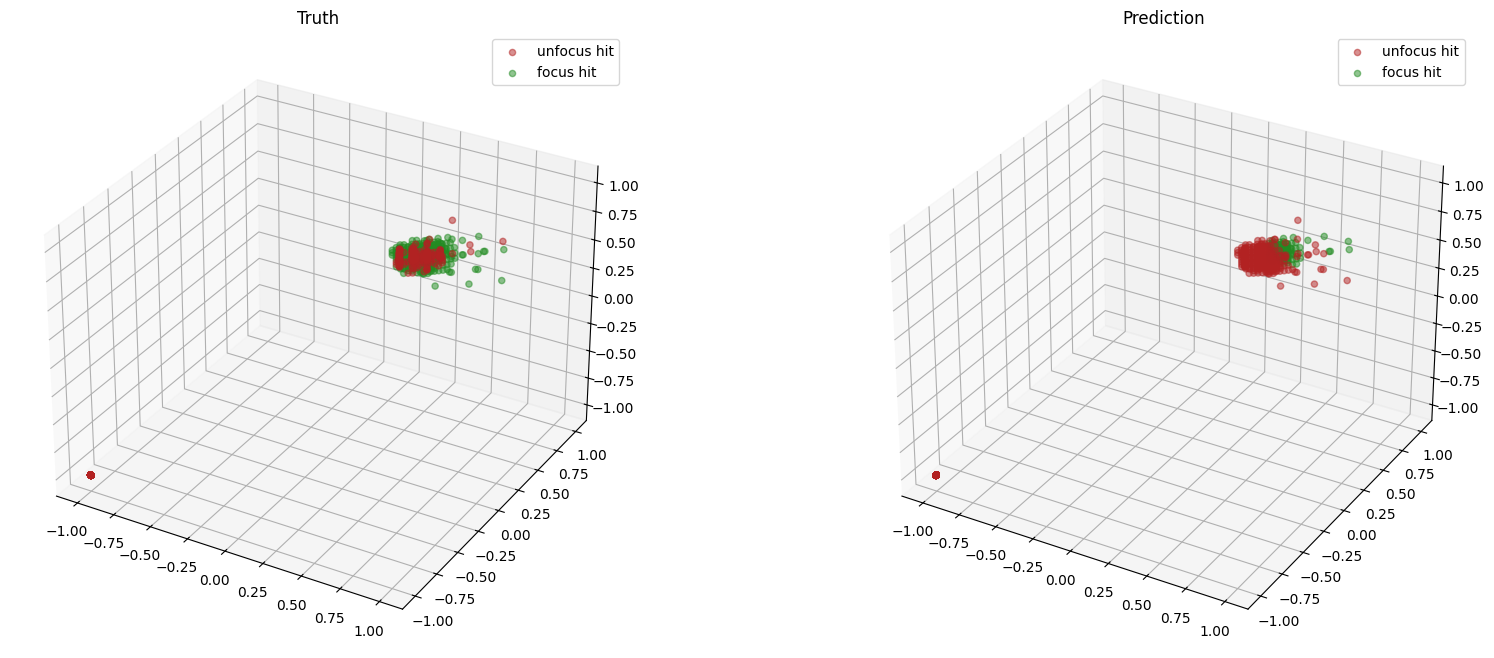

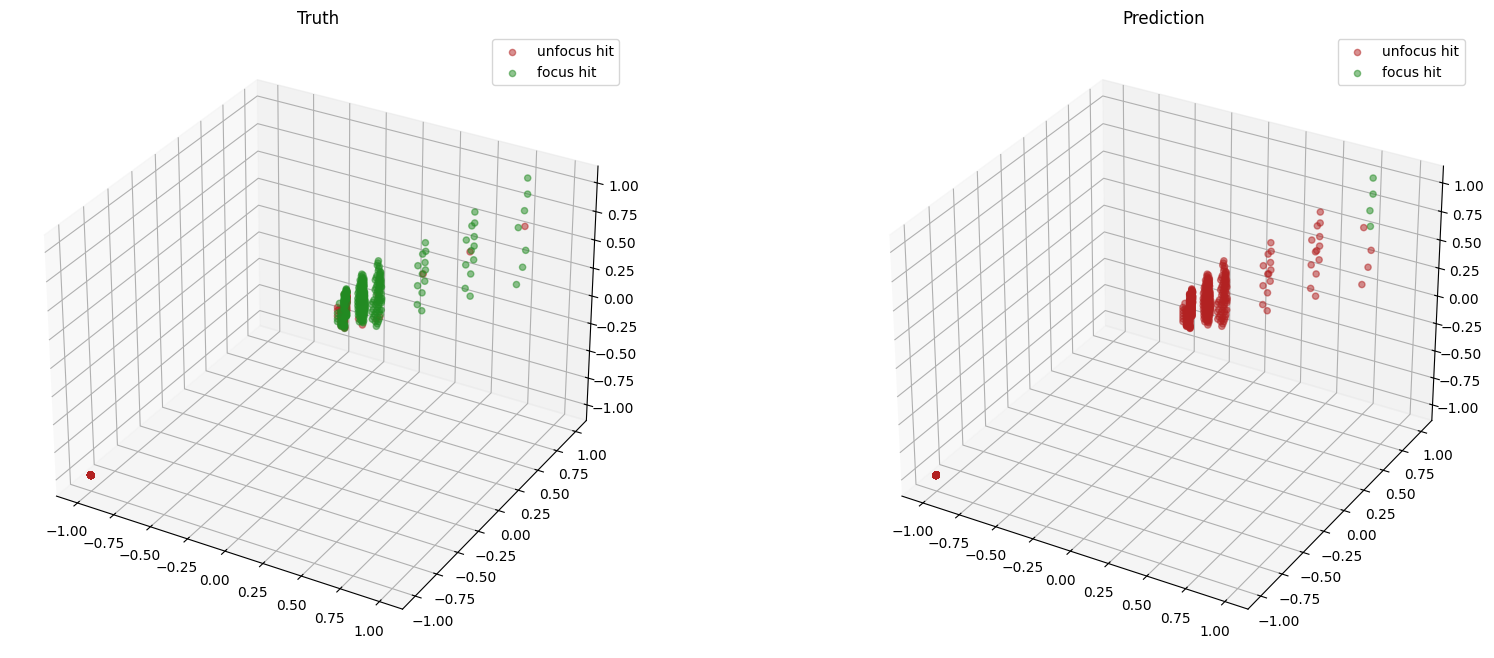

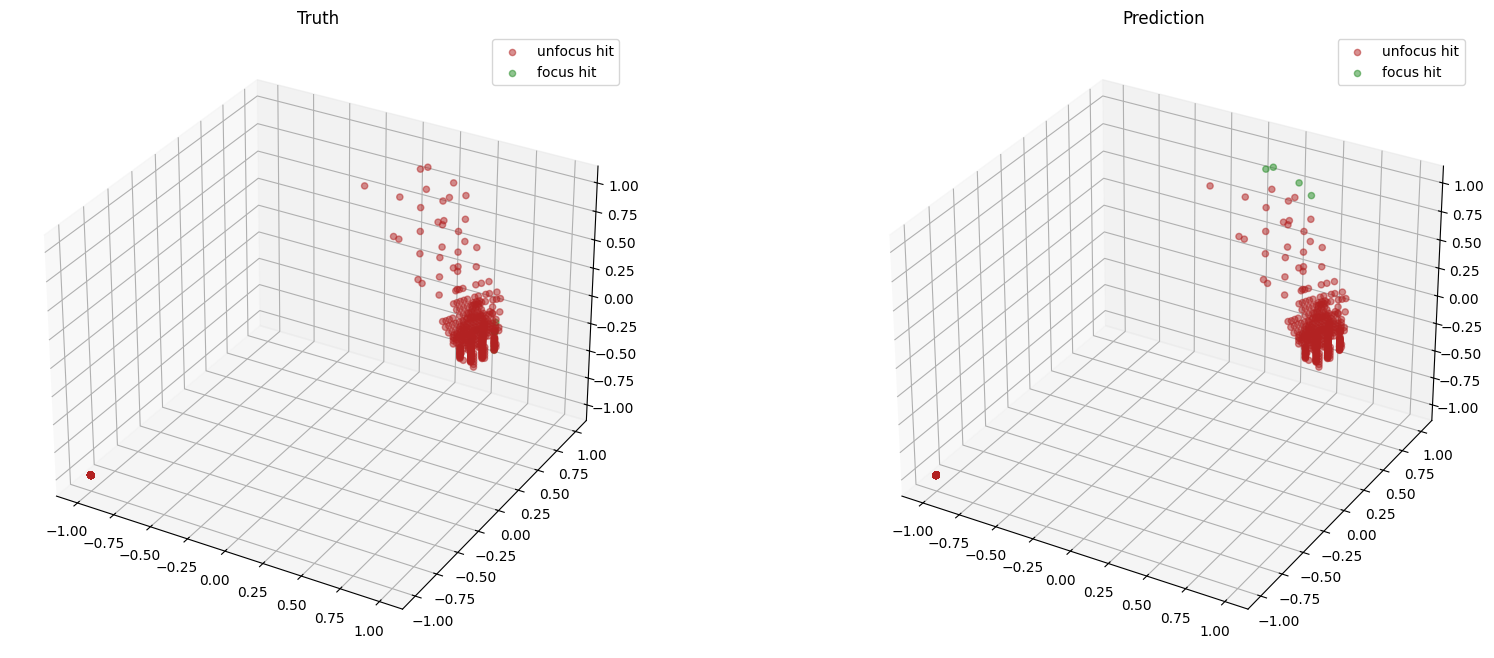

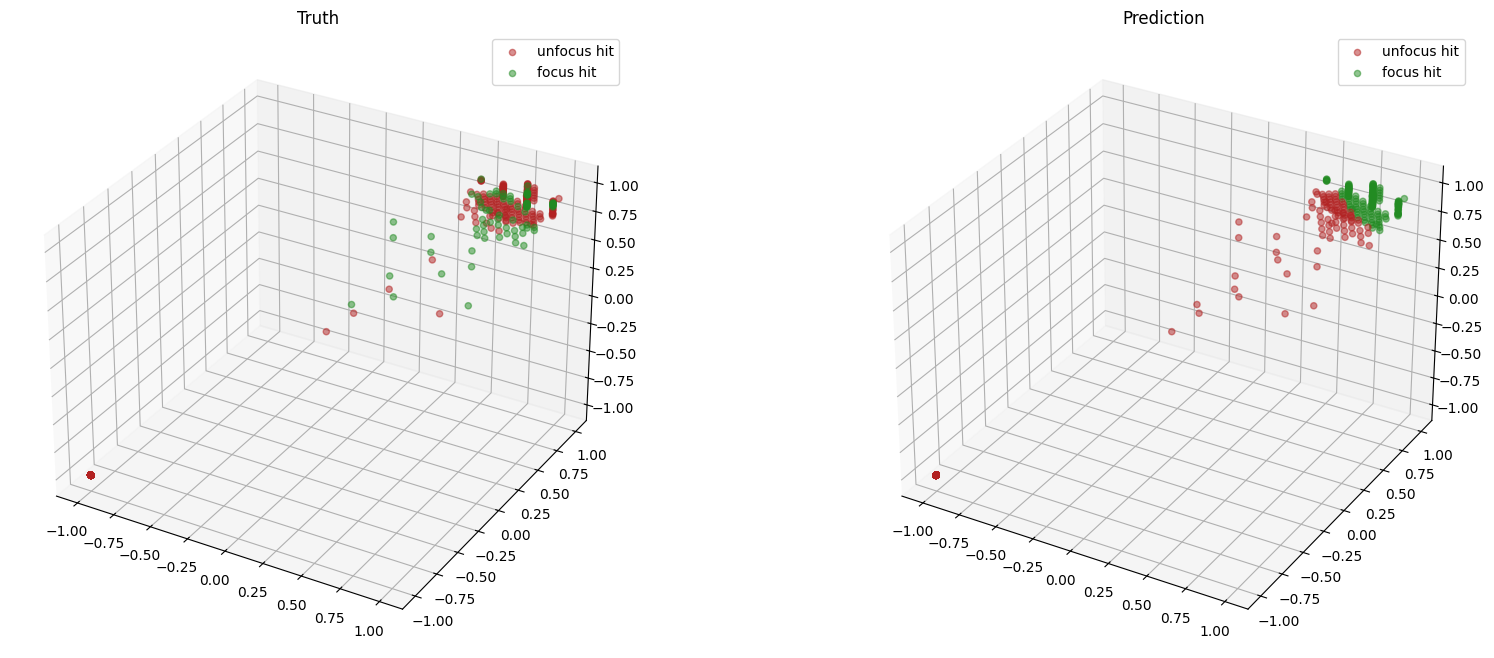

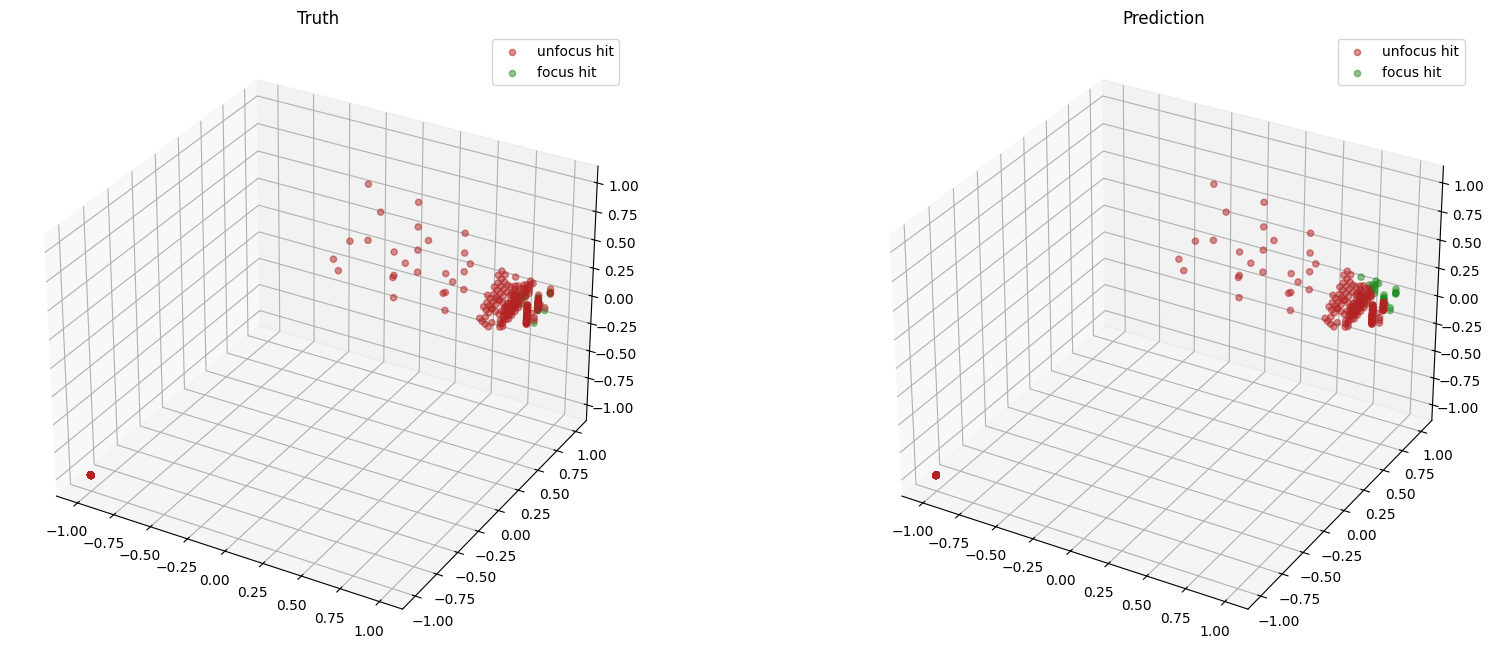

In [43]:
from tensorflow.keras.losses import binary_crossentropy

validation_batch = next(iter(val_dataset))
pred_probs = segmentation_model.predict(validation_batch[0])
val_predictions = (pred_probs > 0.5).astype(np.int16)

batch_loss = binary_crossentropy(validation_batch[1], pred_probs)
loss_per_batch = np.mean(batch_loss, axis=1)
top_5 = np.argsort(loss_per_batch, )[-5:][::-1]

columns = [
    # "top rank", 
    "sample id", "loss", "visualization"]
validation_table = wandb.Table(columns=columns)

with wandb.init(project="mlops-ai_infn", entity="lclissa", name="visual-inspection-2",
                job_type="eval", config=experiment_config,
                notes="Visualization of samples leading to top 5 losses") as run:
    
    _ = run.use_artifact("train_data:latest")
    _ = run.use_artifact("val_data:latest")
    _ = run.use_artifact("baseline-model:latest")
        
    for i, idx in enumerate(top_5):
        fig = plt.figure(figsize=(20, 8))  # Double the width compared to single plot
        ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 cols, first plot
        ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 cols, second plot
        
        # Plotting with ground-truth.
        panel_left = visualize_prediction(validation_batch[0], validation_batch[1], idx, ax1)
        ax1.set_title("Truth")
        
        # Plotting with predictiosn
        panel_right = visualize_prediction(validation_batch[0], val_predictions, idx, ax2, LABELS)
        ax2.set_title("Prediction")
        wandb_pointcloud = wandb.Image(fig)
        sample_loss = loss_per_batch[idx]
        validation_table.add_data(
                # i+1, 
                idx,
                sample_loss,
                wandb_pointcloud
            )
    
        wandb.log({"results/top 5 loss": validation_table})

<div class="alert alert-block alert-info">

For more info check [wandb.keras integration](https://docs.wandb.ai/ref/python/integrations/keras/) and [wandb.Tables](https://docs.wandb.ai/guides/tables)
</div>